In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline

import yaml
import os
import shutil
import re
from datetime import datetime

import pandas as pd
import numpy as np
import random

from sklearn.model_selection import train_test_split

from keras.callbacks import TensorBoard
from keras.preprocessing.image import ImageDataGenerator

Using TensorFlow backend.


In [3]:
from model.cae import CAE

from utils import plot_paired_imgs
from utils import plot_sample_imgs
from utils import read_images

In [4]:
with open('conf/user_conf.yaml', 'r') as f:
    conf = yaml.load(f)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:2: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  


In [5]:
patches_path = os.path.join(conf['data_path'], 'slides', 'patches')
models_path = os.path.join(conf['data_path'], 'models')
image_size = conf['wsi']['patch_size']

In [6]:
slides_df = pd.read_csv(os.path.join(conf['data_path'], 'slides_metadata.csv'), sep='|')

In [7]:
slide_to_patch_columns = ['case_id', 'sample_id', 'slide_id', 'disease_type', 'sample_type', 
                          'percent_normal_cells', 'percent_stromal_cells', 'percent_tumor_cells', 'percent_tumor_nuclei']

## Train/Test split in Slides

The idea is to avoid using patches from the same slide both in train and test.

In [8]:
slides_df = slides_df[slides_df['sample_type'].isin(['Primary Tumor', 'Solid Tissue Normal'])]

In [9]:
slides_df['sample_type'].value_counts(normalize=True)

Primary Tumor          0.907527
Solid Tissue Normal    0.092473
Name: sample_type, dtype: float64

In [10]:
slides_train, slides_test = train_test_split(slides_df, test_size=0.2, 
                                             stratify=slides_df['sample_type'], random_state=conf['seed']) 

In [11]:
slides_train['sample_type'].value_counts(normalize=True)

Primary Tumor          0.908602
Solid Tissue Normal    0.091398
Name: sample_type, dtype: float64

In [12]:
slides_test['sample_type'].value_counts(normalize=True)

Primary Tumor          0.903226
Solid Tissue Normal    0.096774
Name: sample_type, dtype: float64

## Patches DataFrames

__Slides to patches__

In [13]:
regex_slide_id = re.compile('.*(TCGA.*)_\d+_\d+\.png')

In [14]:
patches_df = []

for file_name in os.listdir(patches_path):
    
    if not file_name.endswith('.png'):
        continue
    
    slide_id = regex_slide_id.match(file_name).groups()[0]
    patches_df.append({'slide_id': slide_id, 'filename': file_name})
    
patches_df = pd.DataFrame(patches_df)

In [15]:
patches_df.head(5)

filename                 slide_id
0    TCGA-HZ-8519-01A-01-TS1_29_15.png  TCGA-HZ-8519-01A-01-TS1
1   TCGA-2J-AABF-01A-03-TS3_25_188.png  TCGA-2J-AABF-01A-03-TS3
2   TCGA-IB-AAUM-01A-01-TSA_47_240.png  TCGA-IB-AAUM-01A-01-TSA
3  TCGA-FZ-5919-11A-01-TS1_044_038.png  TCGA-FZ-5919-11A-01-TS1
4    TCGA-IB-AAUS-01A-01-TSA_18_64.png  TCGA-IB-AAUS-01A-01-TSA

In [16]:
training_patches_df = patches_df.merge(slides_train[slide_to_patch_columns], on='slide_id').sample(frac=1, random_state=conf['seed'])
test_patches_df = patches_df.merge(slides_test[slide_to_patch_columns], on='slide_id').sample(frac=1, random_state=conf['seed'])

In [17]:
training_patches_tumor_df = training_patches_df[training_patches_df['sample_type'] == 'Primary Tumor']
training_patches_normal_df = training_patches_df[training_patches_df['sample_type'] == 'Solid Tissue Normal']

test_patches_tumor_df = test_patches_df[test_patches_df['sample_type'] == 'Primary Tumor']
test_patches_normal_df = test_patches_df[test_patches_df['sample_type'] == 'Solid Tissue Normal']

In [18]:
training_patches_tumor_df.head(3)

filename                 slide_id  \
20305    TCGA-FB-A4P5-01A-01-TSA_14_71.png  TCGA-FB-A4P5-01A-01-TSA   
30393  TCGA-FZ-5923-01A-01-TS1_052_030.png  TCGA-FZ-5923-01A-01-TS1   
32217   TCGA-IB-A5ST-01A-01-TSA_35_133.png  TCGA-IB-A5ST-01A-01-TSA   

            case_id         sample_id                  disease_type  \
20305  TCGA-FB-A4P5  TCGA-FB-A4P5-01A  Ductal and Lobular Neoplasms   
30393  TCGA-FZ-5923  TCGA-FZ-5923-01A  Ductal and Lobular Neoplasms   
32217  TCGA-IB-A5ST  TCGA-IB-A5ST-01A  Ductal and Lobular Neoplasms   

         sample_type  percent_normal_cells  percent_stromal_cells  \
20305  Primary Tumor                  20.0                   50.0   
30393  Primary Tumor                   0.0                   30.0   
32217  Primary Tumor                   6.0                   73.0   

       percent_tumor_cells  percent_tumor_nuclei  
20305                 30.0                  40.0  
30393                 70.0                  70.0  
32217                 18.0                  20.0

In [19]:
training_patches_normal_df.head(3)

filename                 slide_id  \
56008  TCGA-FZ-5926-11A-01-TS1_040_043.png  TCGA-FZ-5926-11A-01-TS1   
1432   TCGA-FZ-5919-11A-01-TS1_052_089.png  TCGA-FZ-5919-11A-01-TS1   
17275  TCGA-FZ-5921-11A-01-TS1_034_021.png  TCGA-FZ-5921-11A-01-TS1   

            case_id         sample_id                  disease_type  \
56008  TCGA-FZ-5926  TCGA-FZ-5926-11A  Ductal and Lobular Neoplasms   
1432   TCGA-FZ-5919  TCGA-FZ-5919-11A  Ductal and Lobular Neoplasms   
17275  TCGA-FZ-5921  TCGA-FZ-5921-11A  Ductal and Lobular Neoplasms   

               sample_type  percent_normal_cells  percent_stromal_cells  \
56008  Solid Tissue Normal                   NaN                    NaN   
1432   Solid Tissue Normal                   NaN                    NaN   
17275  Solid Tissue Normal                   NaN                    NaN   

       percent_tumor_cells  percent_tumor_nuclei  
56008                  NaN                   NaN  
1432                   NaN                   NaN  
17275                  NaN                   NaN

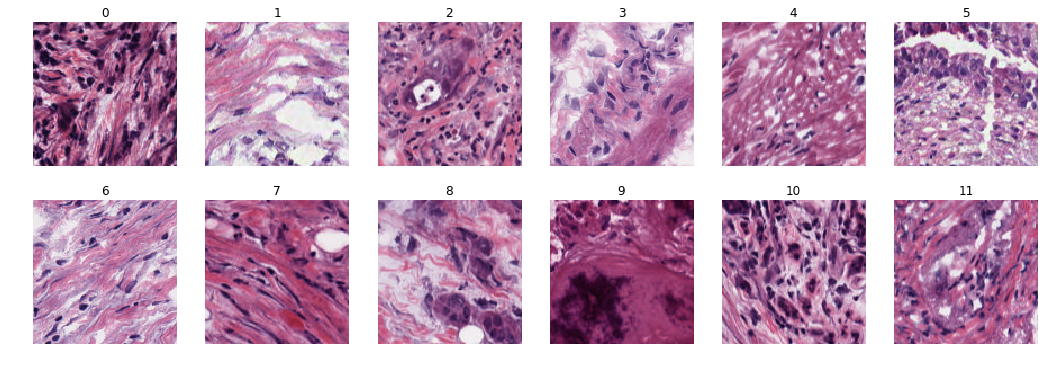

In [20]:
images_tumor_sample = read_images(training_patches_tumor_df['filename'].iloc[:20], patches_path)
plot_sample_imgs(images_tumor_sample, n_rows=2, n_cols=6, shuffle=False)

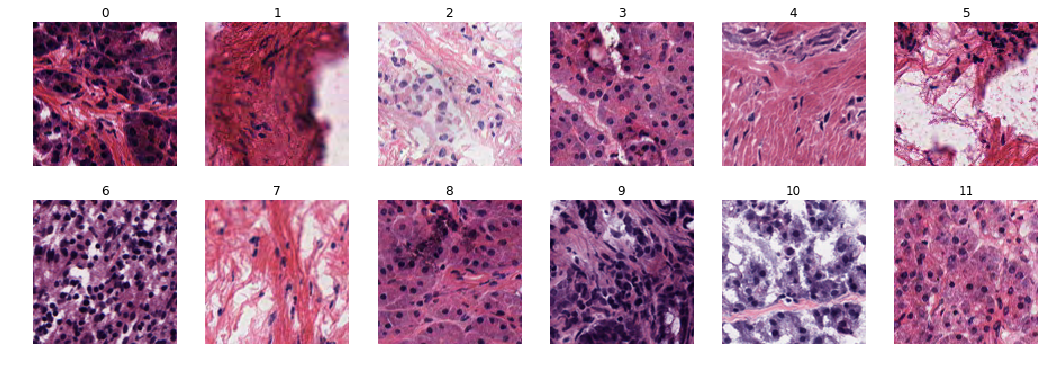

In [21]:
images_normal_sample = read_images(training_patches_normal_df['filename'].iloc[:20], patches_path)
plot_sample_imgs(images_normal_sample, n_rows=2, n_cols=6, shuffle=False)

__Save__

In [22]:
training_patches_df.to_csv(os.path.join(conf['data_path'], 'train.csv'), sep='|', index=False)
test_patches_df.to_csv(os.path.join(conf['data_path'], 'test.csv'), sep='|', index=False)

## Train model

__Image generators__

In [23]:
train_datagen = ImageDataGenerator(validation_split=0.2, rescale=1/255)

train_generator = train_datagen.flow_from_dataframe(training_patches_df, directory=patches_path, x_col='filename', 
                                                    target_size=(image_size, image_size), color_mode='rgb', class_mode='input', 
                                                    subset='training', seed=conf['seed'])

validation_generator = train_datagen.flow_from_dataframe(training_patches_df, directory=patches_path, x_col='filename', 
                                                         target_size=(image_size, image_size), color_mode='rgb', class_mode='input', 
                                                         subset='validation', seed=conf['seed'])

Found 47159 images.
Found 11789 images.


In [24]:
test_datagen = ImageDataGenerator(rescale=1/255)

test_generator = test_datagen.flow_from_dataframe(test_patches_df, directory=patches_path, x_col='filename', 
                                                  target_size=(image_size, image_size), color_mode='rgb', class_mode='input', 
                                                  seed=conf['seed'])

Found 13317 images.


__Train Model__

In [30]:
# initialize ConvAutoEncoder model
cae = CAE(input_shape=(image_size, image_size, 3), latent_features=256, filters=[8,16,32],
          path=os.path.join(models_path, 'model_test'))

In [31]:
tb = TensorBoard(log_dir='../logs/model_test', 
                 write_grads=True, write_images=True, histogram_freq=0)

In [27]:
EPOCHS = 4

cae.model.fit_generator(generator = train_generator, 
                        validation_data = validation_generator,
                        steps_per_epoch = len(train_generator),
                        validation_steps = len(validation_generator),
                        epochs = EPOCHS, 
                        callbacks = [tb])

Instructions for updating:
Use tf.cast instead.
Epoch 1/4


KeyboardInterrupt: 

In [50]:
cae.save()

__Evaluation__

In [53]:
cae.model.evaluate_generator(test_generator, steps=len(test_generator))

0.021109577228079563

__Output examples__

In [54]:
X_train = next(train_generator)[0]
X_train_out = cae.model.predict(X_train)

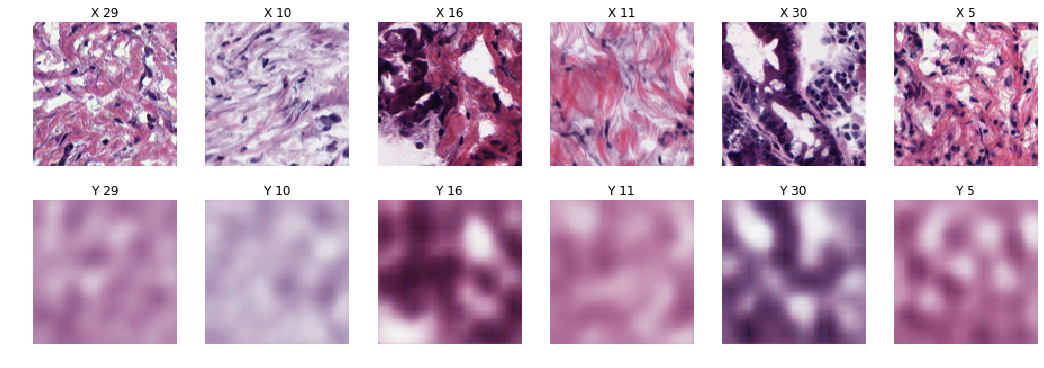

In [55]:
plot_paired_imgs(X_train, X_train_out, N=6)

In [58]:
X_test = next(test_generator)[0]
X_test_out = cae.model.predict(X_test)

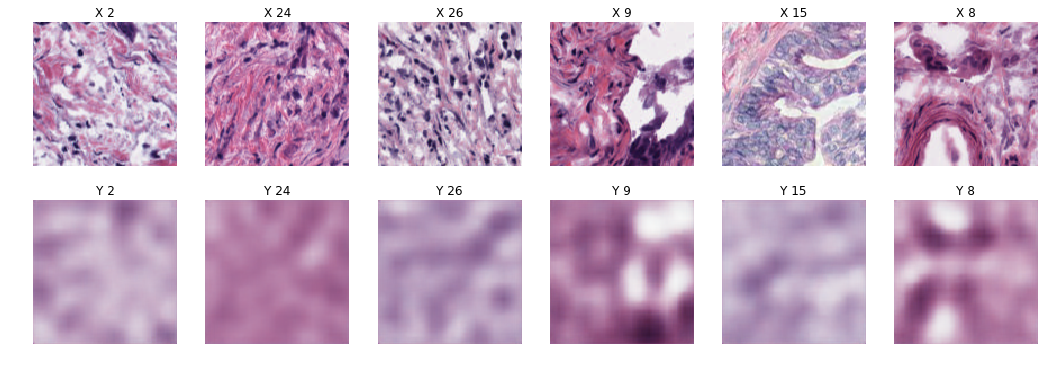

In [59]:
plot_paired_imgs(X_test, X_test_out, N=6)

__Multiple models__

In [28]:
models = [{'id': 1, 'filters': [8,16,32], 'latent_features': 256},
          {'id': 2, 'filters': [8,16,32], 'latent_features': 512},
          {'id': 3, 'filters': [8,16,32], 'latent_features': 1024},
          {'id': 4, 'filters': [8,16,32,64], 'latent_features': 512}]

In [29]:
EPOCHS = 30

for model in models:
    
    print()
    
    cae = CAE(input_shape=(image_size, image_size, 3), 
              latent_features=model['latent_features'], 
              filters=model['filters'],
              path=os.path.join(models_path, 'model_{}'.format(model['id'])))
    
    
    tb = TensorBoard(log_dir='../logs/model_{}'.format(model['id']), 
                 write_grads=True, write_images=True, histogram_freq=0)
    
    
    cae.model.fit_generator(generator = train_generator, 
                        validation_data = validation_generator,
                        steps_per_epoch = len(train_generator),
                        validation_steps = len(validation_generator),
                        epochs = EPOCHS, 
                        callbacks = [tb])
    
    cae.save()


Epoch 1/30
1474/1474 [==============================] - 690s 468ms/step - loss: 0.0256 - val_loss: 0.0222
Epoch 2/30
  39/1474 [..............................] - ETA: 1:41 - loss: 0.0225

KeyboardInterrupt: 

## Train Tumor/Normal Models

__Balance tranining data__

In [ ]:
training_patches_tumor_df = training_patches_tumor_df.sample(n=len(training_patches_normal_df), 
                                                             random_state=SEED)

test_patches_tumor_df = training_patches_tumor_df.sample(n=len(test_patches_normal_df), 
                                                         random_state=SEED)

In [ ]:
len(training_patches_tumor_df)

In [ ]:
len(training_patches_normal_df)

__Image generators__

Tumor

In [390]:
train_datagen = ImageDataGenerator(validation_split=0.2, rescale=1/255)

train_tumor_generator = train_datagen.flow_from_dataframe(training_patches_tumor_df, directory=patches_path, x_col='filename', 
                                                          target_size=(image_size, image_size), color_mode='rgb', class_mode='input',
                                                          subset='training', seed=conf['seed'])

validation_tumor_generator = train_datagen.flow_from_dataframe(training_patches_tumor_df, directory=patches_path, x_col='filename', 
                                                               target_size=(image_size, image_size), color_mode='rgb', class_mode='input', 
                                                               subset='validation', seed=conf['seed'])

Found 4978 images.
Found 1244 images.


In [391]:
test_datagen = ImageDataGenerator(rescale=1/255)

test_tumor_generator = test_datagen.flow_from_dataframe(test_patches_tumor_df, directory=patches_path, x_col='filename', 
                                                        target_size=(image_size, image_size), color_mode='rgb', class_mode='input', 
                                                        seed=cong['seed'])

Found 1079 images.


Normal

In [392]:
train_datagen = ImageDataGenerator(validation_split=0.2, rescale=1/255)

train_normal_generator = train_datagen.flow_from_dataframe(training_patches_normal_df, directory=patches_path, x_col='filename', 
                                                           target_size=(image_size, image_size), color_mode='rgb', class_mode='input', 
                                                           subset='training', seed=conf['seed'])

validation_normal_generator = train_datagen.flow_from_dataframe(training_patches_normal_df, directory=patches_path, x_col='filename', 
                                                                target_size=(image_size, image_size), color_mode='rgb', class_mode='input', 
                                                                subset='validation', seed=conf['seed'])

Found 4978 images.
Found 1244 images.


In [393]:
test_datagen = ImageDataGenerator(rescale=1/255)

test_normal_generator = test_datagen.flow_from_dataframe(test_patches_normal_df, directory=patches_path, x_col='filename', 
                                                         target_size=(image_size, image_size), color_mode='rgb', class_mode='input', 
                                                         seed=conf['seed'])

Found 1079 images.


__Train Models__

In [394]:
EPOCHS = 50

In [395]:
# initialize ConvAutoEncoder model
cae_tumor = CAE(input_shape=(image_size, image_size, 3), latent_features=None, filters=[8,16,32],
          path=os.path.join(models_path, 'model_tumor'))

In [396]:
cae_normal = CAE(input_shape=(image_size, image_size, 3), latent_features=None, filters=[8,16,32],
                 path=os.path.join(models_path, 'model_normal'))

In [397]:
tb = TensorBoard(log_dir='../logs/model_tumor, 
                 write_grads=True, write_images=True, histogram_freq=0)

cae_tumor.model.fit_generator(generator = train_tumor_generator, 
                              validation_data = validation_tumor_generator,
                              steps_per_epoch = len(train_tumor_generator),
                              validation_steps = len(validation_tumor_generator),
                              epochs = EPOCHS, 
                              callbacks = [tb])

cae_tumor.save()

Epoch 1/50
156/156 [==============================] - 9s 58ms/step - loss: 0.0294 - val_loss: 0.0211
Epoch 2/50
156/156 [==============================] - 8s 54ms/step - loss: 0.0154 - val_loss: 0.0133
Epoch 3/50
156/156 [==============================] - 8s 53ms/step - loss: 0.0119 - val_loss: 0.0113
Epoch 4/50
156/156 [==============================] - 8s 52ms/step - loss: 0.0107 - val_loss: 0.0105
Epoch 5/50
156/156 [==============================] - 8s 52ms/step - loss: 0.0101 - val_loss: 0.0100
Epoch 6/50
156/156 [==============================] - 8s 52ms/step - loss: 0.0096 - val_loss: 0.0099
Epoch 7/50
156/156 [==============================] - 8s 52ms/step - loss: 0.0093 - val_loss: 0.0093
Epoch 8/50
156/156 [==============================] - 8s 52ms/step - loss: 0.0090 - val_loss: 0.0090
Epoch 9/50
156/156 [==============================] - 8s 53ms/step - loss: 0.0088 - val_loss: 0.0089
Epoch 10/50
156/156 [==============================] - 8s 54ms/step - loss: 0.0086 - val_lo

In [398]:
tb = TensorBoard(log_dir='../logs/model_normal', 
                 write_grads=True, write_images=True, histogram_freq=0)

cae_normal.model.fit_generator(generator = train_normal_generator, 
                              validation_data = validation_normal_generator,
                              steps_per_epoch = len(train_normal_generator),
                              validation_steps = len(validation_normal_generator),
                              epochs = EPOCHS, 
                              callbacks = [tb])

cae_normal.save()

Epoch 1/50
156/156 [==============================] - 9s 60ms/step - loss: 0.0232 - val_loss: 0.0150
Epoch 2/50
156/156 [==============================] - 8s 54ms/step - loss: 0.0136 - val_loss: 0.0128
Epoch 3/50
156/156 [==============================] - 8s 53ms/step - loss: 0.0122 - val_loss: 0.0118
Epoch 4/50
156/156 [==============================] - 8s 52ms/step - loss: 0.0115 - val_loss: 0.0112
Epoch 5/50
156/156 [==============================] - 8s 52ms/step - loss: 0.0110 - val_loss: 0.0110
Epoch 6/50
156/156 [==============================] - 8s 53ms/step - loss: 0.0106 - val_loss: 0.0105
Epoch 7/50
156/156 [==============================] - 8s 53ms/step - loss: 0.0103 - val_loss: 0.0104
Epoch 8/50
156/156 [==============================] - 8s 54ms/step - loss: 0.0100 - val_loss: 0.0105
Epoch 9/50
156/156 [==============================] - 8s 54ms/step - loss: 0.0098 - val_loss: 0.0098
Epoch 10/50
156/156 [==============================] - 8s 54ms/step - loss: 0.0096 - val_lo

__Evaluation__

Tumor

In [399]:
cae_tumor.model.evaluate_generator(test_tumor_generator, steps=len(test_tumor_generator))

0.005762119347659441

In [400]:
cae_tumor.model.evaluate_generator(test_normal_generator, steps=len(test_normal_generator))

0.006109444917791607

Normal

In [401]:
cae_normal.model.evaluate_generator(test_tumor_generator, steps=len(test_tumor_generator))

0.006147554093338307

In [402]:
cae_normal.model.evaluate_generator(test_normal_generator, steps=len(test_normal_generator))

0.006358175396926156

__Examples__

Tumor model - Tumor data

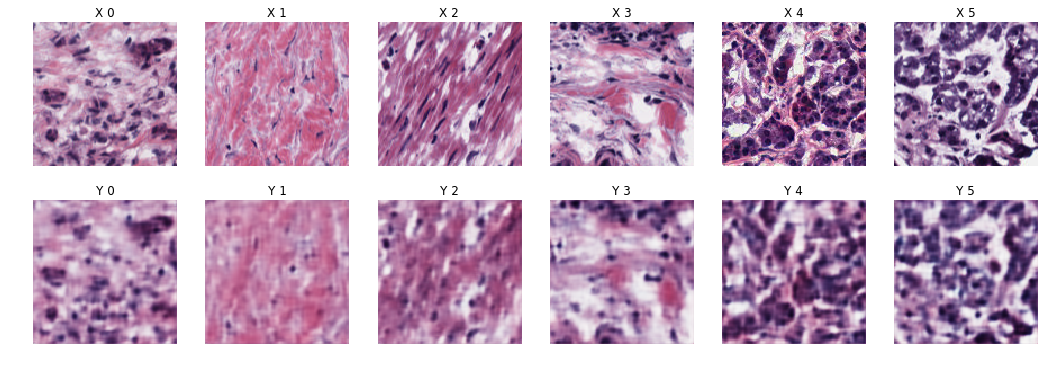

In [415]:
X_test = next(test_tumor_generator)[0]
X_test_out = cae_tumor.model.predict(X_test)
plot_paired_imgs(X_test, X_test_out, N=6)

Tumor model - Normal data

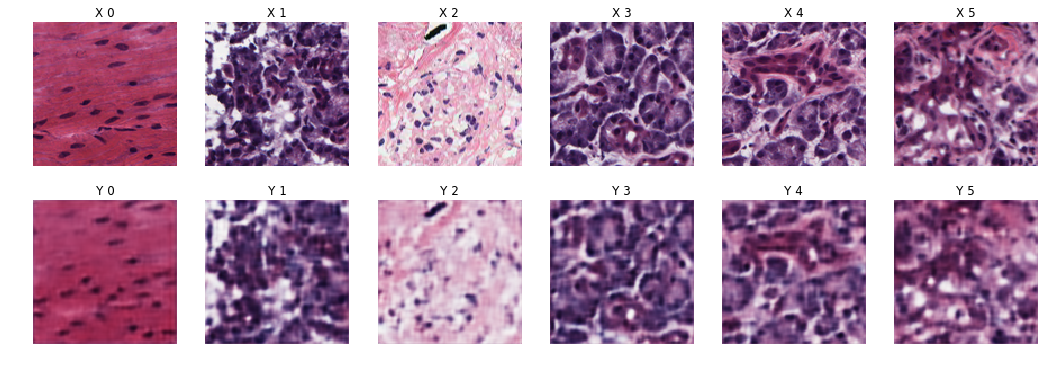

In [414]:
X_test = next(test_normal_generator)[0]
X_test_out = cae_tumor.model.predict(X_test)
plot_paired_imgs(X_test, X_test_out, N=6)

Normal model - Normal data

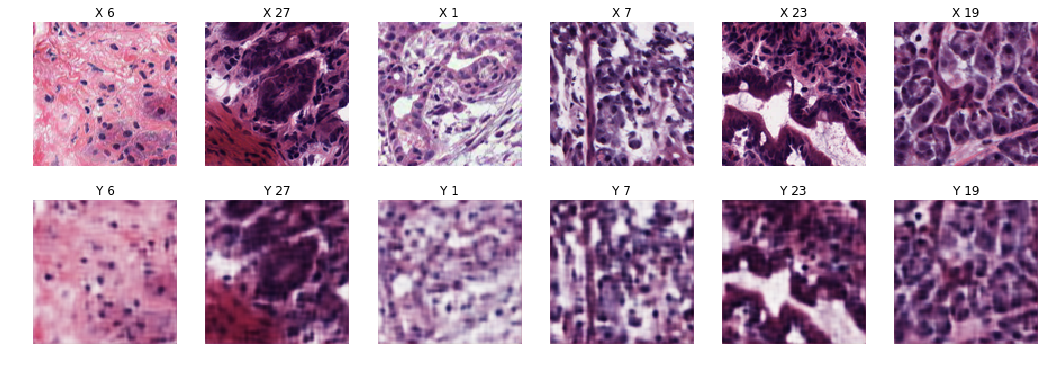

In [416]:
X_test = next(test_normal_generator)[0]
X_test_out = cae_normal.model.predict(X_test)
plot_paired_imgs(X_test, X_test_out, N=6)

Normal model - Tumor data

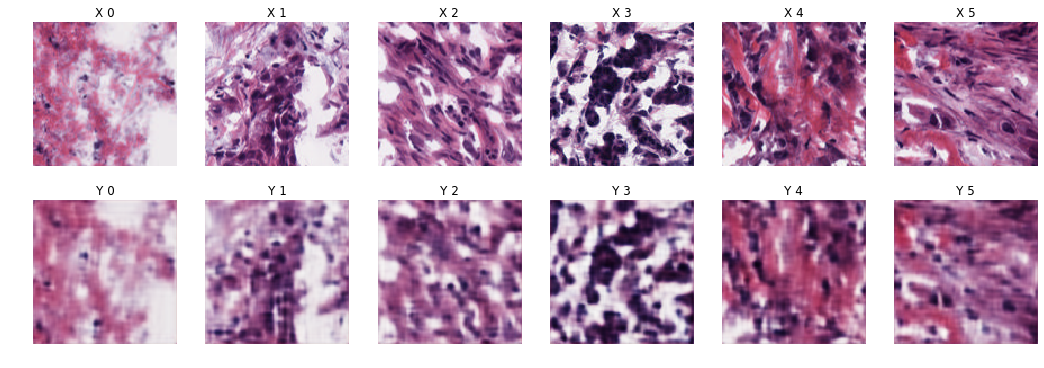

In [417]:
X_test = next(test_tumor_generator)[0]
X_test_out = cae_normal.model.predict(X_test)
plot_paired_imgs(X_test, X_test_out, N=6, shuffle=False)